# **Kütühanelerin Yüklenmesi**

In [1]:
from matplotlib import image
from keras.models import Sequential,Model, model_from_json
# Filtreleme #  Dense Gizli Katmaları(hidden layer)
from keras.layers import Dense,Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization,Dropout
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# **Drive Hesabına Bağlanma**

In [2]:
# Kimlik Doğrulama
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive

Mounted at /gdrive
/gdrive




# **Eğitim ve Test Verilerini İnceleyeceğiz**







In [3]:
root='/gdrive/MyDrive/DuyguTanıma/'
data=pd.read_csv(root+'fer2013/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## **Eğitim Verisi İçin Ön İşleme Adımları**

In [5]:
train_data=data[data.Usage=="Training"]
train_data  

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


In [6]:
# İlk OLarak Pikselleri Boşluktan Ayırarak Liste İçerisine Aldık
train_pixels=train_data.pixels.str.split(" ").tolist()

train_pixels=pd.DataFrame(train_pixels,dtype=int)
train_images=train_pixels.values
train_images=train_images.astype(np.float)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [7]:
# DataFrame İçerisindeki Resimlerin Piksel Değerlerini Numy Dizisine Çevirdik
print(train_images)
print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [8]:
# Görüntüyü 48x48 Boyutlandıracağız
def show(img):
    show_image=img.reshape(48,48)

    plt.axis('off')
    # cmap= Gri Şeklinde Göstersin
    plt.imshow(show_image, cmap='gray')

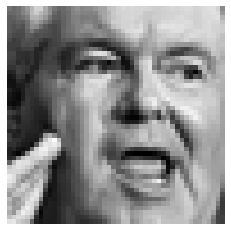

In [9]:
# Rastgele Bir Resmi Gösterelim
show(train_images[778])

In [10]:
data.emotion.value_counts().sort_index()

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

In [11]:
# Duyguları Düz Hale Getirdik (ravel)
train_labels_flat = train_data["emotion"].values.ravel()
#(7,) 0 indeksini aldık // Benzersiz olan Duyguları Saydı
train_labels_count=np.unique(train_labels_flat).shape[0]
print(train_labels_count)

7


In [12]:
# Derin Öğrenme İle Tahmin Edeceğimiz İçin y_train Değerlerimizi 0-1 Arasına Çekmemiz Lazım
def dense_to_one_hot(labels_dense,num_classes):
  num_labels=labels_dense.shape[0]
  index_offset=np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels,num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] =1
  return labels_one_hot

In [13]:
y_train= dense_to_one_hot(train_labels_flat , train_labels_count)
y_train= y_train.astype(np.uint8)
pd.DataFrame(y_train)

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
28704,0,0,1,0,0,0,0
28705,1,0,0,0,0,0,0
28706,0,0,0,0,1,0,0
28707,1,0,0,0,0,0,0


## **TEST Verisi İçin Ön İşleme Adımları**


In [14]:
# x_test Değerlerimiz Aynı Şekil 0-1 Arasına ALmamız Lazım
test_data=data[data.Usage=="PublicTest"]
test_data

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest
...,...,...,...
32293,4,178 176 172 173 173 174 176 173 166 166 206 22...,PublicTest
32294,3,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...,PublicTest
32295,4,255 255 255 255 255 255 255 255 255 255 255 25...,PublicTest
32296,4,33 25 31 36 36 42 69 103 132 163 175 183 187 1...,PublicTest


In [15]:
# İlk OLarak Pikselleri Boşluktan Ayırarak Liste İçerisine Aldık
test_pixels=test_data.pixels.str.split(" ").tolist()

test_pixels=pd.DataFrame(test_pixels,dtype=int)
test_images=test_pixels.values
test_images=test_images.astype(np.float)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [16]:
# DataFrame İçerisindeki Resimlerin Piksel Değerlerini Numy Dizisine Çevirdik
print(test_images)
print(test_images.shape)

[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]
(3589, 2304)


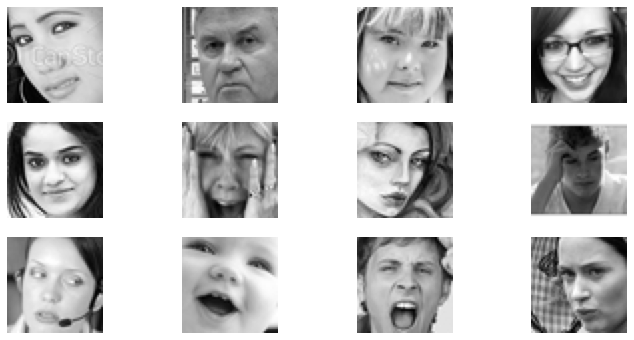

In [17]:
# Rastgele Bir Resmi Gösterelim
plt.figure(0,figsize=(12,6))
for i in range(1,13):
  #i.ninci indeksteki resime çizdir
  plt.subplot(3,4,i)
  # eksenler kapalı
  plt.axis('off')

  img=test_images[i].reshape(48,48)
  plt.imshow(img,cmap='gray')

In [18]:
# Duyguları Düz Hale Getirdik (ravel)
test_labels_flat = test_data["emotion"].values.ravel()
#(7,) 0 indeksini aldık // Benzersiz olan Duyguları Saydı
test_labels_count=np.unique(test_labels_flat).shape[0]
print(test_labels_count)

7


In [19]:
# Derin Öğrenme İle Tahmin Edeceğimiz İçin y_train Değerlerimizi 0-1 Arasına Çekmemiz Lazım
y_test= dense_to_one_hot(test_labels_flat , test_labels_count)
y_test= y_test.astype(np.uint8)
pd.DataFrame(y_test)

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
3584,0,0,0,0,1,0,0
3585,0,0,0,1,0,0,0
3586,0,0,0,0,1,0,0
3587,0,0,0,0,1,0,0


# **EVRİŞİMLİ SİNİR AĞININ MODELE TANILTILMASI**

In [20]:

# Derin Ağımızda Katman Oluşturmak İçin Kerasın Sequential Modelini Kullanacaz
model= Sequential()

# 1.Katman Filtreleme (Convolutional )
# 32 kanallı ,3 kernel_size = Filtre Boyutu 3x3
# data_format= Yükselik,Genişlik,Kanal (Renk Sayısı) bilgisi sonda olacak şekilde
# kernel_initialize = Başlangıç ağırlıklarını belirler
# input_shape = Giriş Boyutu
# 3 RGB (RED,GREEN,BLUE)

model.add(Conv2D(32,3, data_format='channels_last',kernel_initializer="he_normal",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2.Katman
model.add(Conv2D(64,3))
# BatchNormalization   /// Geriye Yayılımda  Katmanın Eğitiminin hızlanmasını sağlar.
# Normalizasyon Girdilerin dağılımının ortalamasını sıfır, standart sapmasını 1 olacak hale getirmektir. Değerler -1 ile +1 Arasına Alınır
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2)) #strides = Adım aralığı 2 şer atlayacak
model.add(Dropout(0.5)) # %50 Unutma İşlemi (Nöron Silme - Dropout)

# Pooling Yaptığımız İçin Kanal Sayısı Değişmez Yine 64 Oldu
# 3. Katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 4. Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

#5.Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2)) #strride = Adım aralığı 2 şer atlayacak
model.add(Dropout(0.5)) # %50  Unutma İşlemi (Nöron Silme - Dropout)
 
# Tam Bağlantı Katmanı (Düzleştirme Yapacağız)
# Flatte Vektörün Elemanları Azalıyor( Dense katmanı ile Sinir Ağı Uyguladık)
# 2048 Vektörü 128 İndiriyoruz
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5)) # %50  Unutma İşlemi (Nöron Silme - Dropout)


# Çıkış Katmanı
# Sınıflandırmada 7 duygu var
model.add(Dense(7))
model.add(Activation('softmax')) # Sınıflandırıcı yapabileceğim aktivasyon

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# MODELİN ÖZETİNİ GÖRME
# Katmanlarda Öğrenilen Parametre Sayısı
# Ortaklamada Öğrenme Olmaz
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

Eğitim ve Test Kümelerinin Eleman Sayısı , Yükseklik ve Genişlik , Kanal Sayısı (Renk Sayısı)-(1-Gri) Ekrana Yazdıracaz

In [21]:
# Oluşan Güncel Durumda ki Resimleri (x_train,x_test) bağımsız değişkenlere atadık
x_train =train_images.reshape(-1,48,48,1)
x_test=test_images.reshape(-1,48,48,1)
print(f"Bağımsız Train Değeri: {x_train.shape}\nBağımsız Test Değeri: {x_test.shape}")

Bağımsız Train Değeri: (28709, 48, 48, 1)
Bağımsız Test Değeri: (3589, 48, 48, 1)


Duygu Durumuda Aynı Şekil Yazdıralım


In [22]:
# Bağımlı Değerler
print(f"Bağımlı Train Değeri: {y_train.shape}\nBağımlı Test Değeri: {y_test.shape}")

Bağımlı Train Değeri: (28709, 7)
Bağımlı Test Değeri: (3589, 7)


# **MODELİN EĞİTİLMESİ**

Eğitim sonucunda en iyi ağırlıkları face_model.h5 dosyasına kaydederek 

Eğitilmiş bu modeli aşağıda yüklediğimiz resmin başarısını ölçtük

In [23]:
# En Başarılı Ağırlıkların Kaydedilmesi
controlResult=ModelCheckpoint(root+'data/face_model.h5',verbose=1,save_best_only=True)
epochs=40
batchSize=100

# Modelin Çalıştırılması
hist=model.fit(x_train,y_train,
               epochs=epochs,
               shuffle=True, # Karışık Şekilde Görselleri Alır
               batch_size=batchSize,
               validation_data=(x_test,y_test), # Doğrulama İşlemi İçin Public Test Kullanacaz
               callbacks=[controlResult],verbose=2) # callbacks işlem sırasında ekrana ayrıntılı verilerin dökülmesini sağlıyoruz.
                 

# Modeli Json Formatta Kaydettik
model_json=model.to_json()
with open (root + 'data/face_model.json','w') as json_file:
  json_file.write(model_json)

Epoch 1/40

Epoch 1: val_loss improved from inf to 1.49515, saving model to /gdrive/MyDrive/DuyguTanıma/data/face_model.h5
288/288 - 19s - loss: 1.9053 - accuracy: 0.2928 - val_loss: 1.4952 - val_accuracy: 0.4436 - 19s/epoch - 66ms/step
Epoch 2/40

Epoch 2: val_loss improved from 1.49515 to 1.39587, saving model to /gdrive/MyDrive/DuyguTanıma/data/face_model.h5
288/288 - 7s - loss: 1.5408 - accuracy: 0.4046 - val_loss: 1.3959 - val_accuracy: 0.4648 - 7s/epoch - 24ms/step
Epoch 3/40

Epoch 3: val_loss improved from 1.39587 to 1.35076, saving model to /gdrive/MyDrive/DuyguTanıma/data/face_model.h5
288/288 - 7s - loss: 1.4191 - accuracy: 0.4539 - val_loss: 1.3508 - val_accuracy: 0.4801 - 7s/epoch - 24ms/step
Epoch 4/40

Epoch 4: val_loss improved from 1.35076 to 1.27010, saving model to /gdrive/MyDrive/DuyguTanıma/data/face_model.h5
288/288 - 7s - loss: 1.3566 - accuracy: 0.4787 - val_loss: 1.2701 - val_accuracy: 0.5085 - 7s/epoch - 24ms/step
Epoch 5/40

Epoch 5: val_loss improved from 1.

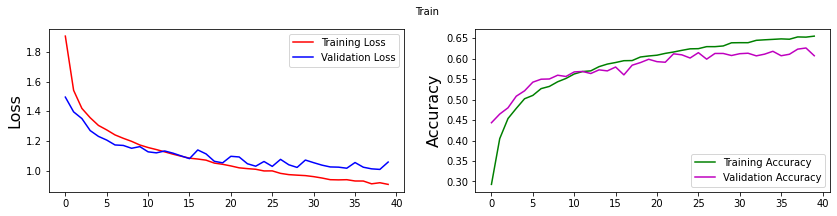

In [24]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.suptitle('Train',fontsize=10)
plt.ylabel('Loss',fontsize=16)
plt.plot(hist.history['loss'],color='r',label='Training Loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy',fontsize=16)
plt.plot(hist.history['accuracy'],color='g',label='Training Accuracy')
plt.plot(hist.history['val_accuracy'],color='m',label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [25]:
from keras.models import load_model
from keras.preprocessing import image

In [26]:
model_best= load_model(root+'data/face_model.h5')

In [29]:
os.chdir('/gdrive/MyDrive/DuyguTanıma/images')

In [30]:
# Klasör İçindeki Resimler
!ls

17e641c5-f18a-4a40-9855-2cab7b6554c3.jpg
1_org.jpg
53b57449-46da-4fe3-a88a-6091367d1714.jpg
ataturk.jpg
BB255610-DBA0-4F30-8333-B92CFFCEAE58.jpg
CB3D584A-5D3E-40E3-B6CE-069440FDF5A2.jpg
IMG-20200728-WA0009.jpg
Kemal_Sunal.jpg
unnamed.jpg
unnamed.png


Resmi yükledikten sonra tahmin için boyutlandırma işlemi yaptık

In [31]:
# Klasörden Çekmek İçin Resmi
image_path=root+"images/ataturk.jpg"

# ORJİNAL RESİM
test_image_original=image.load_img(image_path)
# BOYUTUNU 48X48 Çevirp Grileştirdik 
# Resmi Piksel Hale Dönüştürdük (Tensor Haline Geldi)
test_image=image.load_img(image_path,target_size=(48,48),grayscale=True)
test_data =image.img_to_array(test_image)
test_data=np.expand_dims(test_data,axis=0)
test_data=np.vstack([test_data])

# Model_best ile yüklediğimiz resimleri tahmin ettik
# batch 1 resim atacağımız için 1 dedik
results=model_best.predict(test_data,batch_size=1)
results

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.14611173, 0.00319963, 0.1665838 , 0.17945786, 0.33650777,
        0.03513979, 0.13299938]], dtype=float32)

# **Grafiğin Oluşturulması**

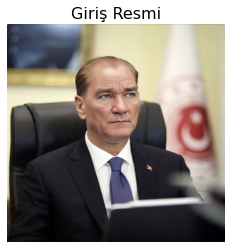

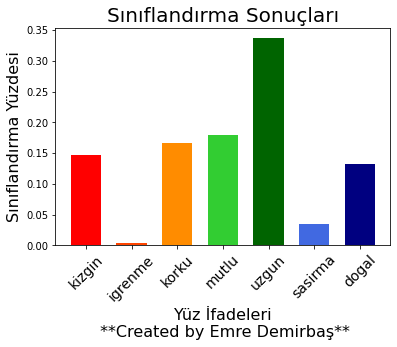

In [32]:
class_names=['kizgin','igrenme','korku','mutlu','uzgun','sasirma','dogal']
ind=0.1+0.6*np.arange(len(class_names))
width=0.4

color_list=['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

plt.imshow(test_image_original)
plt.title('Giriş Resmi',fontsize=16)
plt.axis('off')
plt.show()

for i in  range(len(class_names)):
  plt.bar(ind[i],results[0][i],width,color=color_list[i])

plt.title('Sınıflandırma Sonuçları',fontsize=20)
plt.xlabel("Yüz İfadeleri\n **Created by Emre Demirbaş**",fontsize=16)
plt.ylabel("Sınıflandırma Yüzdesi",fontsize=16)

plt.xticks(ind,class_names,rotation=45,fontsize=14)
plt.show()